In [1]:
!pip install vit-pytorch linformer

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-13 06:53:06          10640  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6507  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2451  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2647  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 531M/544M [00:02<00:00, 232MB/s]
100% 544M/544M [00:02<00:00, 241MB/s]
 94% 256M/271M [00:01<00:00, 176MB/s]
100% 271M/271M [00:01<00:00, 176MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 114MB/s]


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# loading Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

In [10]:
# import Linformer
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [11]:
# import torch and related libraries 
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile 

In [12]:
#sklearn to split the data
from sklearn.model_selection import train_test_split 

In [13]:
#definining batch size, epocs, learning rate and gamma for training  
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [14]:
#Load data
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [15]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

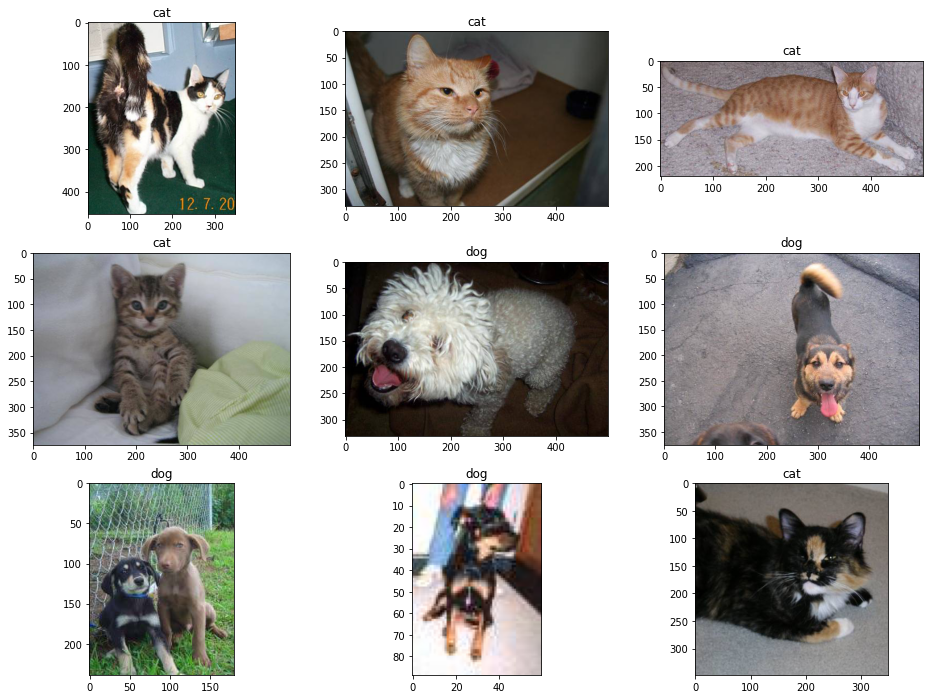

In [16]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [17]:
seed = 20

In [18]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [19]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [20]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [21]:
#defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [22]:
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [23]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [25]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [26]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [27]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)



In [38]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy) 
    test_losses.append(epoch_val_loss)
    test_accuracy.append(epoch_val_accuracy)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6975 - acc: 0.5019 - val_loss : 0.6917 - val_acc: 0.5069



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6911 - acc: 0.5219 - val_loss : 0.6883 - val_acc: 0.5358



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6831 - acc: 0.5521 - val_loss : 0.6950 - val_acc: 0.5237



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6782 - acc: 0.5698 - val_loss : 0.6753 - val_acc: 0.5744



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6721 - acc: 0.5768 - val_loss : 0.6801 - val_acc: 0.5639



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6637 - acc: 0.5888 - val_loss : 0.6702 - val_acc: 0.5801



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6535 - acc: 0.6055 - val_loss : 0.6509 - val_acc: 0.6025



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6439 - acc: 0.6161 - val_loss : 0.6460 - val_acc: 0.6133



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6364 - acc: 0.6301 - val_loss : 0.6364 - val_acc: 0.6268



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6270 - acc: 0.6393 - val_loss : 0.6452 - val_acc: 0.6171



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6167 - acc: 0.6550 - val_loss : 0.6387 - val_acc: 0.6315



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6149 - acc: 0.6500 - val_loss : 0.6252 - val_acc: 0.6406



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6098 - acc: 0.6619 - val_loss : 0.6257 - val_acc: 0.6325



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6050 - acc: 0.6645 - val_loss : 0.6130 - val_acc: 0.6527



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6023 - acc: 0.6681 - val_loss : 0.6056 - val_acc: 0.6628



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5980 - acc: 0.6729 - val_loss : 0.6108 - val_acc: 0.6634



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5938 - acc: 0.6776 - val_loss : 0.5982 - val_acc: 0.6648



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5930 - acc: 0.6763 - val_loss : 0.6123 - val_acc: 0.6620



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5909 - acc: 0.6823 - val_loss : 0.5960 - val_acc: 0.6748



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5866 - acc: 0.6841 - val_loss : 0.5992 - val_acc: 0.6685



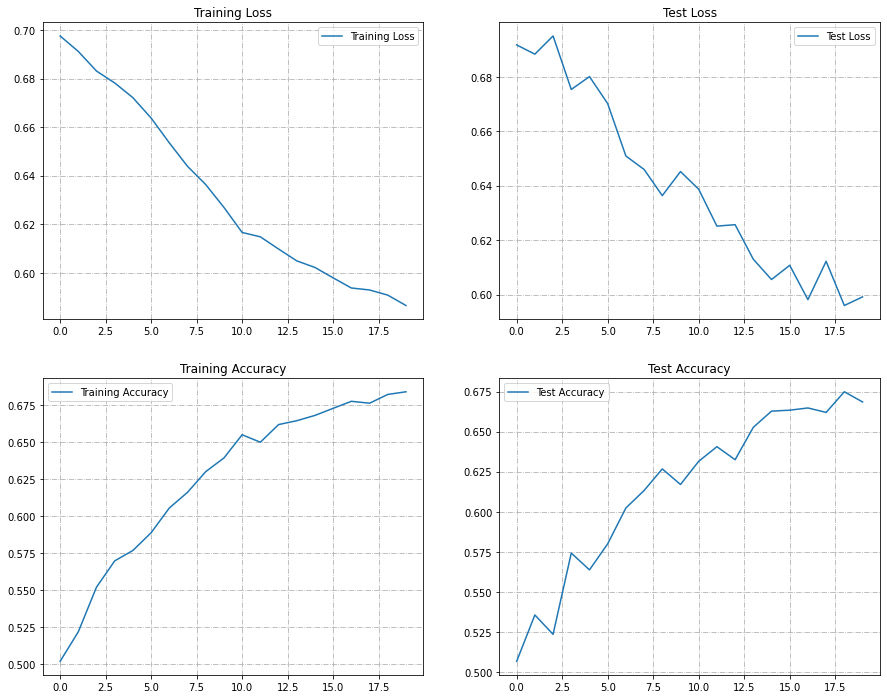

In [39]:
fig, axs = plt.subplots(2,2,figsize=(15,12))
axs[0, 0].plot(train_losses, label='Training Loss')
axs[0, 0].grid(linestyle='-.')
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()

axs[1, 0].plot(train_accuracy, label='Training Accuracy')
axs[1, 0].grid(linestyle='-.')
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].legend()

axs[0, 1].plot(test_losses, label='Test Loss')
axs[0, 1].grid(linestyle='-.')
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend()

axs[1, 1].plot(test_accuracy, label='Test Accuracy')
axs[1, 1].grid(linestyle='-.')
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()	

In [40]:
torch.save(model.state_dict(),"/content/gdrive/MyDrive/EVA/ViT_model.pt")

In [41]:
model_path = '/content/gdrive/MyDrive/EVA/ViT_model.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [42]:
classes = ['cat', 'dog']

In [43]:
!ls -l /content/data/test | head

total 303992
-rw-r--r-- 1 root root 54902 Aug 14 17:13 10000.jpg
-rw-r--r-- 1 root root 21671 Aug 14 17:13 10001.jpg
-rw-r--r-- 1 root root 28895 Aug 14 17:13 10002.jpg
-rw-r--r-- 1 root root 40146 Aug 14 17:13 10003.jpg
-rw-r--r-- 1 root root 21252 Aug 14 17:13 10004.jpg
-rw-r--r-- 1 root root  8888 Aug 14 17:13 10005.jpg
-rw-r--r-- 1 root root 11972 Aug 14 17:13 10006.jpg
-rw-r--r-- 1 root root 25560 Aug 14 17:13 10007.jpg
-rw-r--r-- 1 root root 39583 Aug 14 17:13 10008.jpg


Text(0.5, 1.0, 'Pred label: cat')

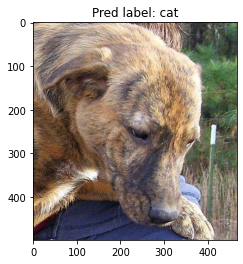

In [50]:
img1 = Image.open("/content/data/test/10000.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

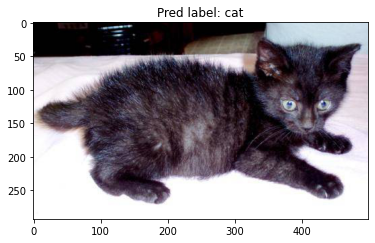

In [51]:
img1 = Image.open("/content/data/test/10001.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

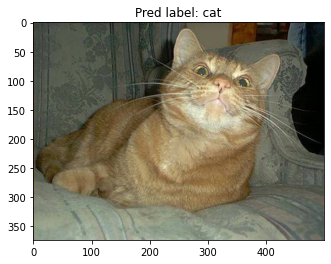

In [46]:
img1 = Image.open("/content/data/test/10002.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

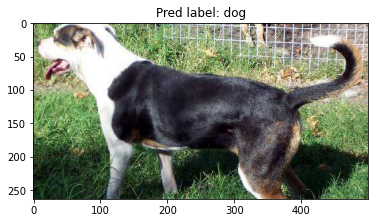

In [47]:
img1 = Image.open("/content/data/test/10003.jpg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")